In [83]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader, TensorDataset

from torchsummary import summary

import time

In [84]:
# train data
X_TRAIN = np.load("Xtrain_Classification_Part1.npy")
Y_TRAIN = np.load("Ytrain_Classification_Part1.npy")

# test data
X_TEST = np.load("Xtest_Classification_Part1.npy")


In [85]:
# reshape train data and convert to tensor
X_TRAIN = X_TRAIN.reshape(X_TRAIN.shape[0], 1, 50, 50) / 255
Y_TRAIN = Y_TRAIN.reshape(Y_TRAIN.shape[0], 1)

X_TRAIN_tensor = torch.Tensor(X_TRAIN).float()
Y_TRAIN_tensor = torch.Tensor(Y_TRAIN).float()

# reshape test data and convert to tensor
X_TEST = X_TEST.reshape(X_TEST.shape[0], 1, 50, 50) / 255

X_TEST_tensor = torch.Tensor(X_TRAIN).float()

In [86]:
# split the data
trainX, devX, trainY, devY = train_test_split(X_TRAIN_tensor, Y_TRAIN_tensor)

# convert to dataloader
trainSet = TensorDataset(trainX, trainY)
devSet = TensorDataset(devX, devY)

trainLoader = DataLoader(trainSet)
devLoader = DataLoader(devSet)


In [87]:
def createGervasio():
    class gervasio(nn.Module):
        def __init__(self) -> None:
            super().__init__()

            self.conv1 = nn.Conv2d(1, 10, kernel_size=5, stride=1, padding=1)
            size = np.floor((np.floor((50 + 2 * 1 - 5) / 1) + 1) / 2)

            self.conv2 = nn.Conv2d(10, 20, kernel_size=5, stride=1, padding=1)
            size = np.floor((np.floor((size + 2 * 1 - 5) / 1) + 1) / 2)

            expectSize = np.floor((size + 2 * 0 - 1) / 1) + 1
            expectSize = 20 * int(expectSize ** 2)

            self.fc1 = nn.Linear(expectSize, 50)

            self.out = nn.Linear(50, 1)

        def forward(self, x):
            x = F.relu(F.avg_pool2d(self.conv1(x), 2))

            x = F.relu(F.avg_pool2d(self.conv2(x), 2))

            nUnits = x.shape.numel() / x.shape[0]
            x = x.view(-1, int(nUnits))

            x = F.relu(self.fc1(x))

            x = torch.sigmoid(self.out(x))

            return x

    # criar o gervasio
    Gervasio = gervasio()

    # loss func
    lossF = nn.BCELoss()  # binary cross entropy with logits

    optimizer = torch.optim.Adam(Gervasio.parameters(), lr=0.001)

    return Gervasio, lossF, optimizer


In [88]:
def trainGervasio():
    # number of epochs
    numepochs = 10

    # create a new model
    Gervasio, lossfun, optimizer = createGervasio()

    # initialize losses and accuracies
    losses = torch.zeros(numepochs)
    trainAcc = torch.zeros(numepochs)
    devAcc = torch.zeros(numepochs)

    # loop over epochs
    for epochi in range(numepochs):

        # loop over training data batches
        Gervasio.train()
        batchAcc = []
        batchLoss = []
        for X, Y in trainLoader:

            # forward pass and loss
            Y_pred = Gervasio(X)
            loss = lossfun(Y_pred, Y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute accuracy
            match = ((Y_pred >= 0.5).float() == Y).float()
            batchAcc.append(match)  # add to list of accuracies

        # now that we've trained through the batches, get their average training accuracy
        trainAcc[epochi] = 100*np.mean(batchAcc)

        # and get average losses across the batches
        losses[epochi] = np.mean(batchLoss)
        
        # test accuracy
        Gervasio.eval()
        batchAcc = []
        for X, Y in devLoader:
            with torch.no_grad():  # deactivates autograd
                Y_pred = Gervasio(X)

            # compute accuracy
            match = ((Y_pred >= 0.5).float() == Y).float()
            batchAcc.append(match)  # add to list of accuracies
            
        devAcc[epochi] = 100*np.mean(batchAcc)

    # function output
    return trainAcc, devAcc, losses, Gervasio


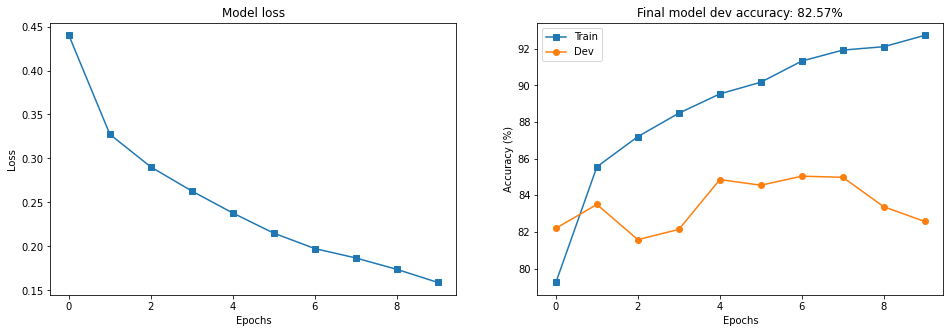

In [89]:
trainAcc, devAcc, losses, Gervasio = trainGervasio()

fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(losses, "s-")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_title("Model loss")

ax[1].plot(trainAcc, "s-", label="Train")
ax[1].plot(devAcc, "o-", label="Dev")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_title(f"Final model dev accuracy: {devAcc[-1]:.2f}%")
ax[1].legend()

plt.show()


In [90]:
summary(Gervasio, (1,50,50))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 48, 48]             260
            Conv2d-2           [-1, 20, 46, 46]           5,020
            Linear-3                   [-1, 50]         529,050
            Linear-4                    [-1, 1]              51
Total params: 534,381
Trainable params: 534,381
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.50
Params size (MB): 2.04
Estimated Total Size (MB): 2.55
----------------------------------------------------------------


In [91]:
Y_pred = Gervasio(X_TEST_tensor)

male


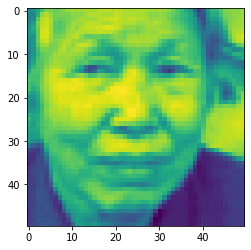

female


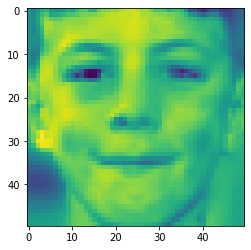

female


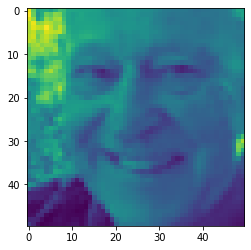

female


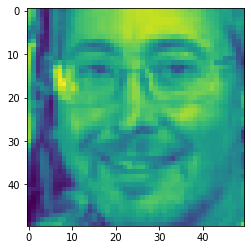

male


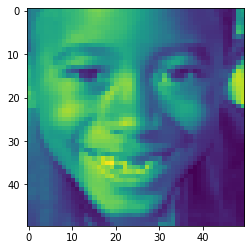

male


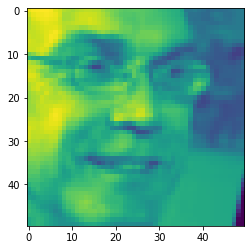

female


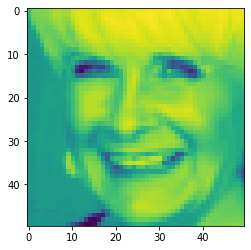

female


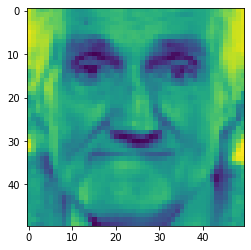

female


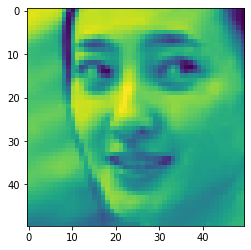

male


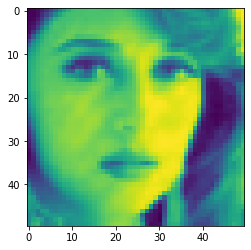

female


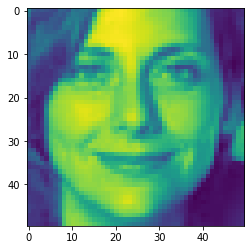

male


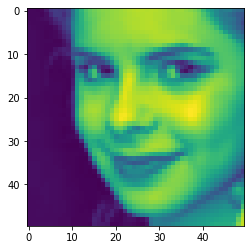

female


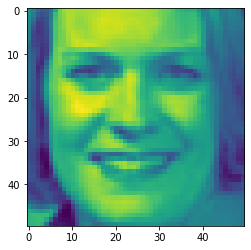

male


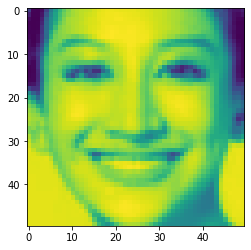

male


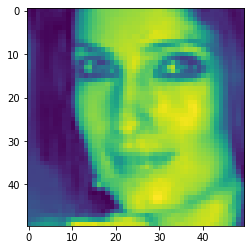

male


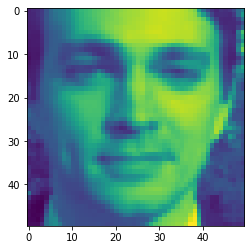

male


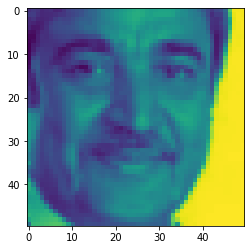

male


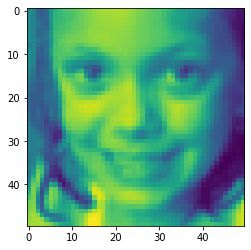

male


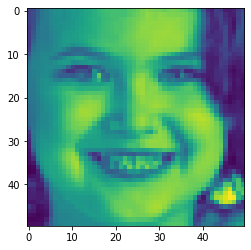

female


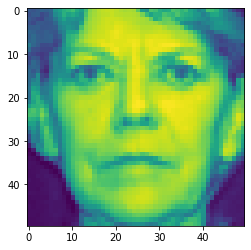

male


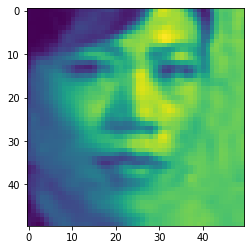

male


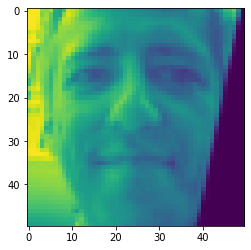

male


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [92]:
X_TEST = X_TEST.reshape(X_TEST.shape[0], 50, 50, 1)

for i in range(Y_pred.shape[0]):
  if Y_pred[i] >= 0.5:
    print("male")
  else:
    print("female")
    
  plt.imshow(X_TEST[i])
  plt.show()
  time.sleep(1)